In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
inspector = inspect(engine)

In [36]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [37]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [38]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [39]:
#Inspect Class
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [40]:
#Inspect Class
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [41]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [42]:
# Find the most recent date in the data set.
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent

('2017-08-23',)

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago
# Perform a query to retrieve the data and precipitation scores
#Max was the aggrigation that made the graph match, but why only use max???
sel = [Measurement.date, func.max(Measurement.prcp)]
lastyear = session.query(*sel).filter(Measurement.date > year_ago).group_by(Measurement.date).all()
lastyear
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(lastyear, columns = ['Date', 'Rainfall'])
df

,Date,Rainfall
0,2016-08-24,2.28
1,2016-08-25,0.21
2,2016-08-26,0.04
3,2016-08-27,0.18
4,2016-08-28,2.07
...,...,...
360,2017-08-19,0.09
361,2017-08-20,0.01
362,2017-08-21,0.56
363,2017-08-22,0.50


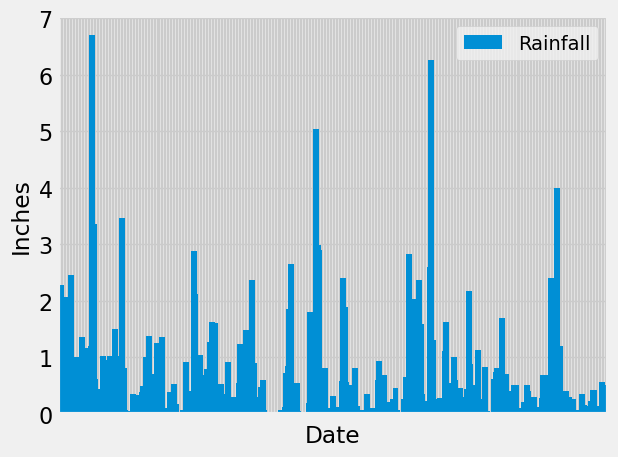

In [99]:
# Sort the dataframe by date
# Did this step in query (order by)
# Use Pandas Plotting with Matplotlib to plot the data

ax = df.plot(kind = "bar", width = 4)
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
ax.xaxis.set_major_formatter(plt.NullFormatter()) # couldnt figure out how to group x axis labels
plt.tick_params(bottom= False)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()


In [96]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Rainfall
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


# Exploratory Station Analysis

In [44]:
#Inspect Classes
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [45]:
# Design a query to calculate the total number of stations in the dataset
station = session.query(Station.id).count()
station

9

In [51]:
stat = session.query(Station.station, Station.id).all()
stat

[('USC00519397', 1),
 ('USC00513117', 2),
 ('USC00514830', 3),
 ('USC00517948', 4),
 ('USC00518838', 5),
 ('USC00519523', 6),
 ('USC00519281', 7),
 ('USC00511918', 8),
 ('USC00516128', 9)]

In [128]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [131]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel2 = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
temp = session.query(*sel2).filter(Measurement.station == 'USC00519281').all()
temp

[(54.0, 85.0, 71.66378066378067)]

In [170]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
maxstat = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date > year_ago).all()
maxstat
max_df = pd.DataFrame(maxstat)
max_df

,station,tobs
0,USC00519281,77.0
1,USC00519281,80.0
2,USC00519281,80.0
3,USC00519281,75.0
4,USC00519281,73.0
...,...,...
346,USC00519281,77.0
347,USC00519281,77.0
348,USC00519281,76.0
349,USC00519281,76.0


Text(0.5, 1.0, '')

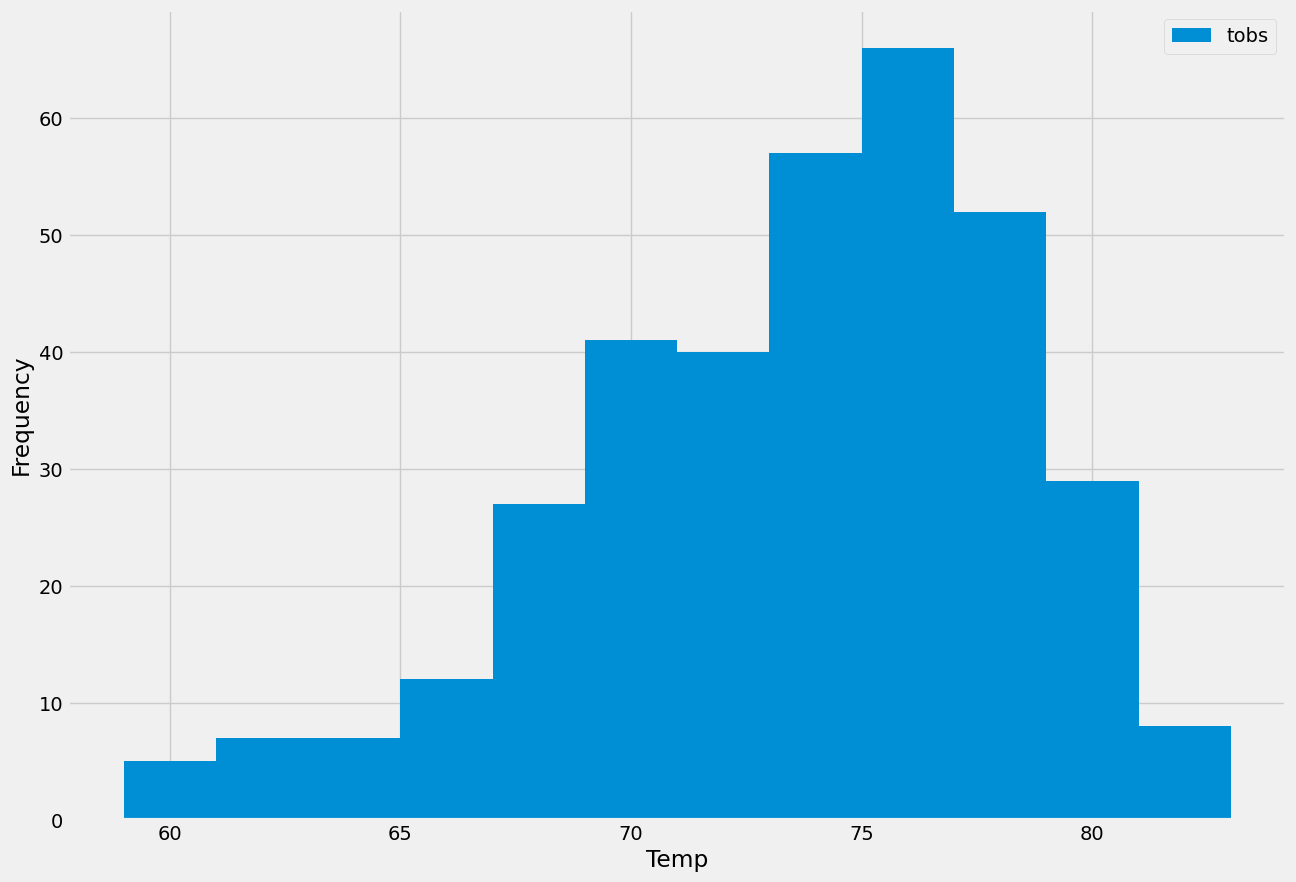

In [175]:
max_df.plot.hist(by = 'station', figsize =(14,10), bins =12, range =[59,83])
plt.xlabel("Temp")
plt.title("")

## Close Session

In [176]:
# Close Session
session.close()